In [23]:
import glob
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdatesx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from typing import List

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# COVID-19 Daily Observation Data

Data from [2019 Novel Coronavirus COVID-19 (2019-nCoV) Data repository](https://github.com/CSSEGISandData/COVID-19) by Johns Hopkins CSSE.

## Load data
We're going to read in all of the data in the [csse_covid_19_daily_reports](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports) directory, and aggregate it into a single `DataFrame`.

First, the dates across the files aren't in a consistent format, so we need a utility to normalize our dates:

In [3]:
def normalize_date(date: str) -> pd.Timestamp:
    """Converts various timestamps into consistent format."""
    return pd.Timestamp(date).replace(hour=0, minute=0, second=0)

assert normalize_date("1/22/2020 17:00") == pd.Timestamp("2020-01-22 00:00:00")
assert normalize_date("01/22/2020 02:00") == pd.Timestamp("2020-01-22 00:00:00")
assert normalize_date("2020-02-02T23:43:02") == pd.Timestamp("2020-02-02 00:00:00")
assert normalize_date("2020-03-23 23:19:34") == pd.Timestamp("2020-03-23 00:00:00")

There are a couple more utilities we need to read in the data:

In [4]:
def list_source_files(dir_name: str) -> List[str]: 
    """Returns a list of all the source files."""
    pattern = r"(\d{2}-\d{2}-\d{4}).csv"
    src = "{}/*.csv".format(dir_name)
    return [f for f in glob.glob(src) if re.search(pattern, f)]

def read_combined_daily_data(file_names: List[str], rename_cols_map):
    """Reads in all the data, combines it in single DataFrame."""
    # Note handling inconsistent column names
    dfs = [pd.read_csv(f).rename(columns=rename_cols_map) for f in files] 
    data = pd.concat(dfs)
    return data

Now we can read in the data, aggregate it, and clean it up:

In [5]:
DIR = "csse_covid_19_daily_reports"

RENAME_COLS = { 'Country_Region': 'Country/Region', 'Province_State': 'Province/State', 
          'Last_Update': 'Last Update'}

# Read in data as single DataFrame
files = list_source_files(DIR)
data = read_combined_daily_data(files, RENAME_COLS)

# Cleanup: select columns NaN -> 0
NUMERIC_COLS = ['Confirmed', 'Deaths', 'Recovered']
data[NUMERIC_COLS] = data[NUMERIC_COLS].fillna(0)
    
# Cleanup: drop anything without cases (removes an error for DC data)
data = data[data['Confirmed'] > 0]

# Cleanup: Augment data with normalized "Date" field
data['Last Update'] = data['Last Update'].apply(normalize_date)

COLUMNS_TO_KEEP = ['Province/State', 'Country/Region', 'Last Update', 'Confirmed', 'Deaths', 'Recovered']

# Cleanup: remove unused columns
data = data[COLUMNS_TO_KEEP]

# This is time series data, so update index and sort
data = data.set_index('Last Update')
data = data.sort_values(by=['Last Update'])

data

,Province/State,Country/Region,Confirmed,Deaths,Recovered
Last Update,,,,,
2020-01-22,Macau,Macau,1.0,0.0,0.0
2020-01-22,NaN,South Korea,1.0,0.0,0.0
2020-01-22,NaN,Thailand,2.0,0.0,0.0
2020-01-22,NaN,Japan,2.0,0.0,0.0
2020-01-22,Zhejiang,Mainland China,10.0,0.0,0.0
...,...,...,...,...,...
2020-03-27,Virginia,US,1.0,0.0,0.0
2020-03-27,Tennessee,US,22.0,0.0,0.0
2020-03-27,Texas,US,1.0,0.0,0.0


Given we set `Last Update` to be the index, we can now access data using date ranges:

In [6]:
data.loc['2020-03-19':'2020-03-21']

,Province/State,Country/Region,Confirmed,Deaths,Recovered
Last Update,,,,,
2020-03-19,NaN,Algeria,87.0,9.0,32.0
2020-03-19,NaN,Latvia,86.0,0.0,1.0
2020-03-19,Tennessee,US,154.0,0.0,0.0
2020-03-19,NaN,Lebanon,157.0,4.0,4.0
2020-03-19,NaN,Vietnam,85.0,0.0,16.0
...,...,...,...,...,...
2020-03-21,NaN,Bulgaria,163.0,3.0,3.0
2020-03-21,NaN,Panama,200.0,1.0,0.0
2020-03-21,Nevada,US,161.0,2.0,0.0


## Confirmed cases

In [93]:
# Source for date formatting legibility tricks: https://stackoverflow.com/a/43631028
def plot_time_series_data(x_col, observations, predictions = None):
    """Renders a line graph for time series data, making graph more legible"""
    fig, ax = plt.subplots()
    ax.plot(x_col, observations)
    
    if predictions is not None:
        ax.plot(x_col, predictions)
    
    # make dates legible
    myFmt = DateFormatter("%m/%d")
    ax.xaxis.set_major_formatter(myFmt)
    
    # rotate dates to improve legibility
    fig.autofmt_xdate()
    plt.show()

### Worldwide
Let's look at worldwide cumulative confirmed cases:

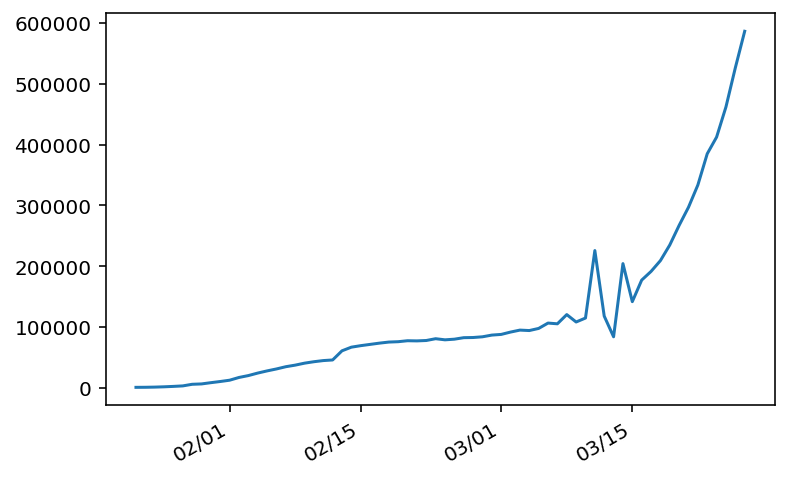

In [94]:
world = data.groupby(data.index).sum()[NUMERIC_COLS]
plot_time_series_data(world.index, world["Confirmed"])

The daily confirmed worldwide cases are noisy between 3/11 and 3/16:

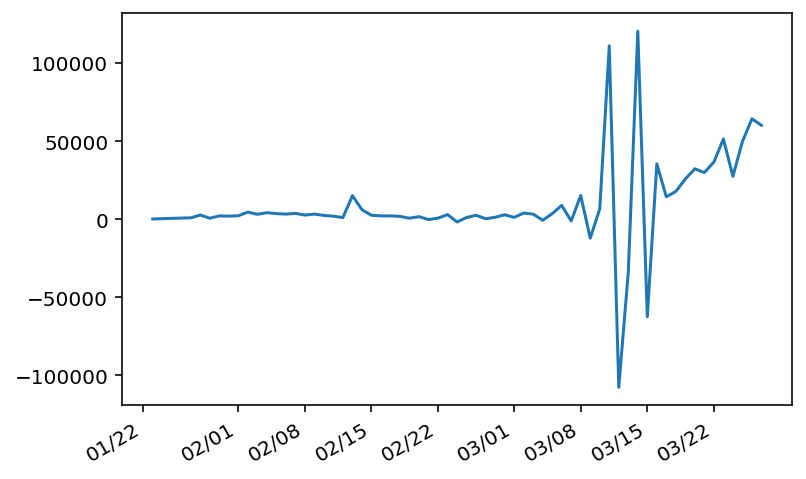

In [9]:
plot_time_series_data(world.index, world["Confirmed"].diff())

We're going to apply a function that removes outliers:

In [10]:
# Is there a better way?
def remove_value(label, df, iteration, deltas, val):
    date = df.index[deltas == val].tolist()[0]
    print("Iteration #{}: found {} change of {} on {}".format(iteration, label, val, date))
    date_idx = df.index.get_loc(date)
    return df.drop(df.index[date_idx])

def remove_outliers(df_original, col_name, iterations): 
    df = df_original.copy()
    """Repeatedly removes minimum and maximum values"""
    
    for i in range(0, iterations):
        deltas = df[col_name].diff()
        df = remove_value("max", df, i, deltas, deltas.max())
        deltas = df[col_name].diff()
        df = remove_value("min", df, i, deltas, deltas.min())
    
    return df

The daily occurances are still surprisingly noisy, given this data is aggregated:

Iteration #0: found max change of 120371.0 on 2020-03-14 00:00:00
Iteration #0: found min change of -107776.0 on 2020-03-12 00:00:00
Iteration #1: found max change of 111003.0 on 2020-03-11 00:00:00
Iteration #1: found min change of -30833.0 on 2020-03-13 00:00:00
Iteration #2: found max change of 64286.0 on 2020-03-26 00:00:00
Iteration #2: found min change of -12196.0 on 2020-03-09 00:00:00


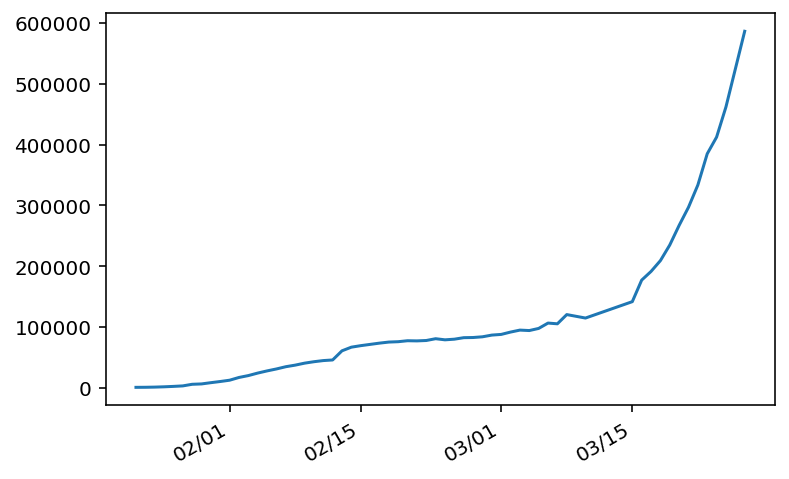

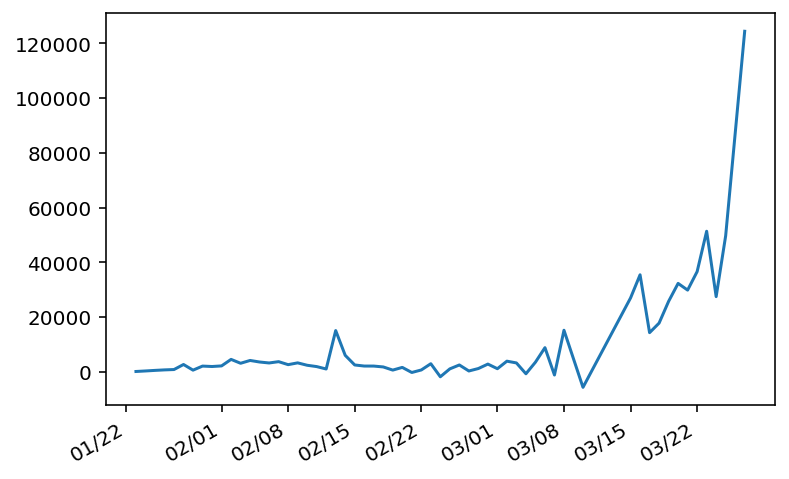

In [11]:
world_smooth = remove_outliers(world, "Confirmed", 3) # number of iterations = suspicious peaks & valleys
plot_time_series_data(world_smooth.index, world_smooth["Confirmed"]) 
plot_time_series_data(world_smooth.index, world_smooth["Confirmed"].diff()) 

Let's fit this data to a polynomial curve, as a benchmark to help us understand the daily confirmed case rates rate of change across different regions:

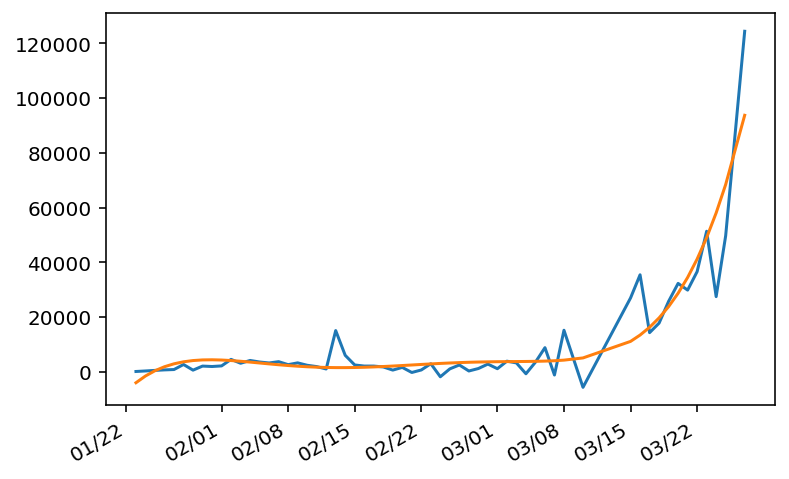

In [125]:
# TODO: this is high. What's reasonable?
DEFAULT_POLYNOMIAL_DEGRESS = 5

def dates_to_date_offsets(dates):
    fn = lambda date: (date - pd.Timestamp('2020-01-22T00:00:00.000000000')).days
    return np.array(list(map(fn, dates)))

def polynomial_date_offsets(X, degree=DEFAULT_POLYNOMIAL_DEGRESS):
    assert X.shape[0] > 1  # Must not pass in one day of data
    assert X.shape[1] == 1
    poly_feat = PolynomialFeatures(degree)
    return poly_feat.fit_transform(X)

def polynomial_regression(X, y):
    assert y.shape == X.shape
    X_poly = polynomial_date_offsets(X)
    model = LinearRegression()
    return model.fit(X_poly, y)

# Fit model
world_date_offsets = dates_to_date_offsets(world_smooth.index.values).reshape(-1, 1)[1:]
world_confirmed_obs = world_smooth["Confirmed"].diff().values.reshape(-1, 1)[1:]
world_confirmed_model = polynomial_regression(world_date_offsets, world_confirmed_obs)

# Graph predictions
world_predictions = world_confirmed_model.predict(polynomial_date_offsets(world_date_offsets))
plot_time_series_data(world_smooth.index[1:], world_smooth["Confirmed"].diff()[1:], np.array(world_predictions))

### Hubei
Let's look at Hubei confirmed cases:

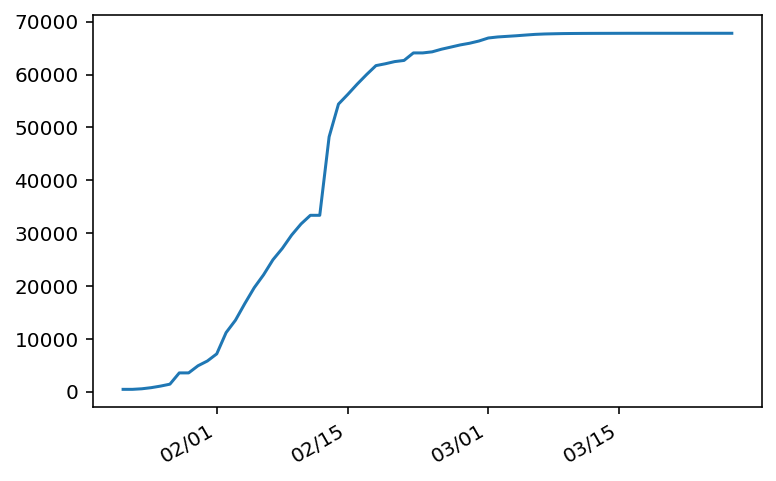

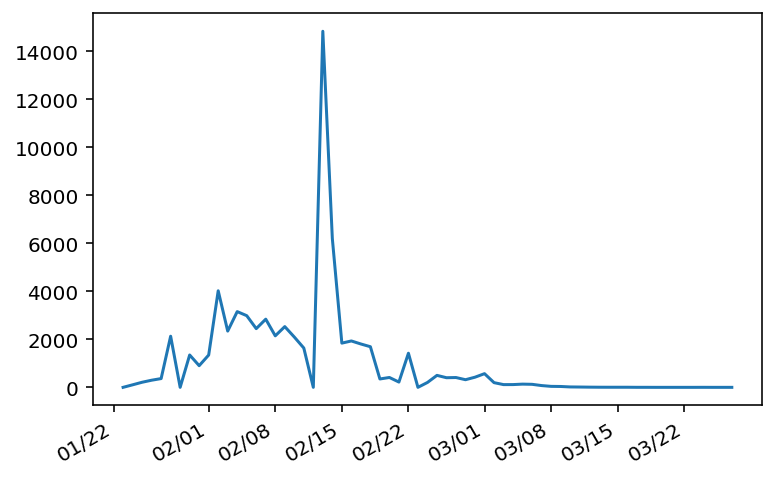

In [12]:
hubei = data.loc[data['Province/State'] == 'Hubei',NUMERIC_COLS]
plot_time_series_data(hubei.index, hubei["Confirmed"])
plot_time_series_data(hubei.index, hubei["Confirmed"].diff())

Hubei daily confirmed cases is difficult to interpret for two reasons:

1. there's a massive spike around 2/12 - 2/14
2. there's a gradual decreases of recorded cases starting around 2/3, but that is followed by the massive spike

Unlike worldwide views, removing outliers would exacerbate the noisiness of the data, as it would remove points within the 2/12 - 2/14 time range, which would result in an even more massive spike.

### Italy
Let's look at cumulative confirmed cases in Italy:

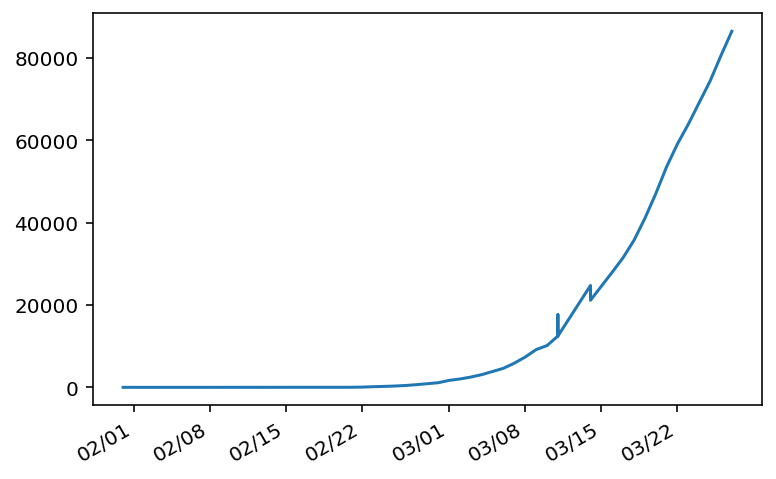

In [13]:
italy = data.loc[data['Country/Region'] == 'Italy']
plot_time_series_data(italy.index, italy["Confirmed"])

Italian daily occurrances are also noisy:

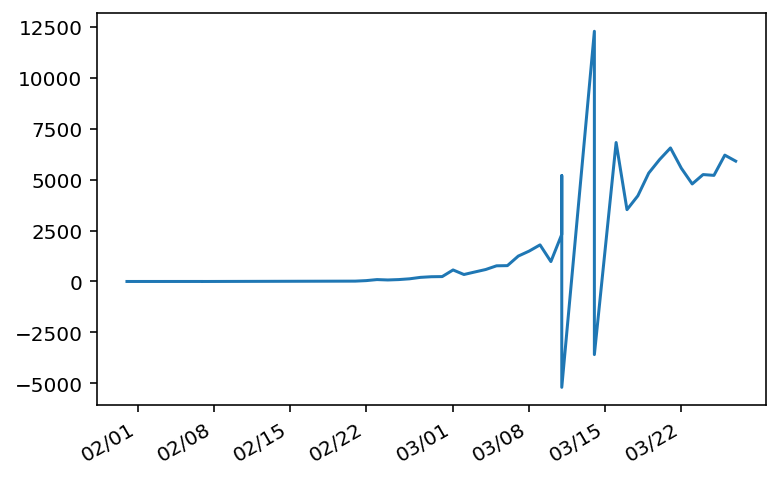

In [14]:
plot_time_series_data(italy.index, italy["Confirmed"].diff())

Let's remove the two spikes:

Iteration #0: found max change of 12285.0 on 2020-03-14 00:00:00
Iteration #0: found min change of -5198.0 on 2020-03-11 00:00:00
Iteration #1: found max change of 17831.0 on 2020-03-16 00:00:00
Iteration #1: found min change of 0.0 on 2020-01-31 00:00:00


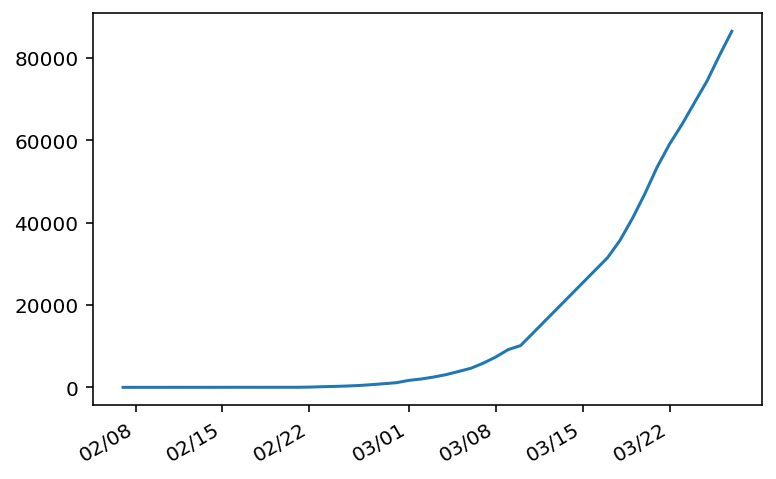

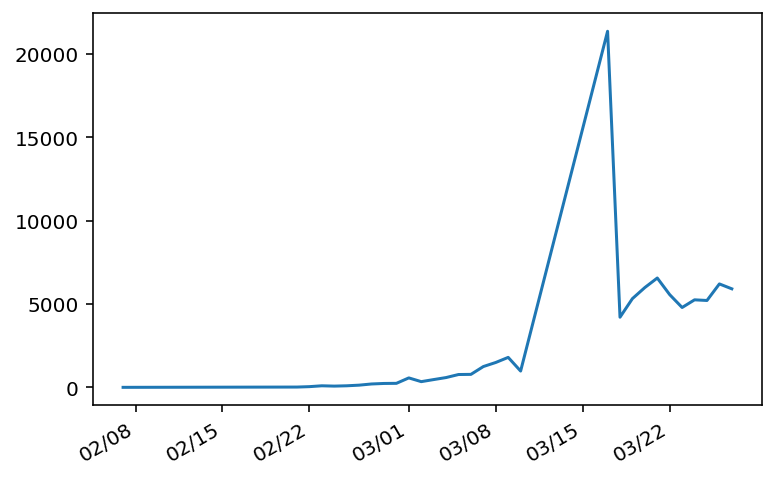

In [15]:
italy_smooth = remove_outliers(italy, "Confirmed", 2) # number of iterations = suspicious peaks & valleys
plot_time_series_data(italy_smooth.index, italy_smooth["Confirmed"]) 
plot_time_series_data(italy_smooth.index, italy_smooth["Confirmed"].diff()) 

Italian daily observations, while growing, doesn't fit the pattern viewed worldwide:

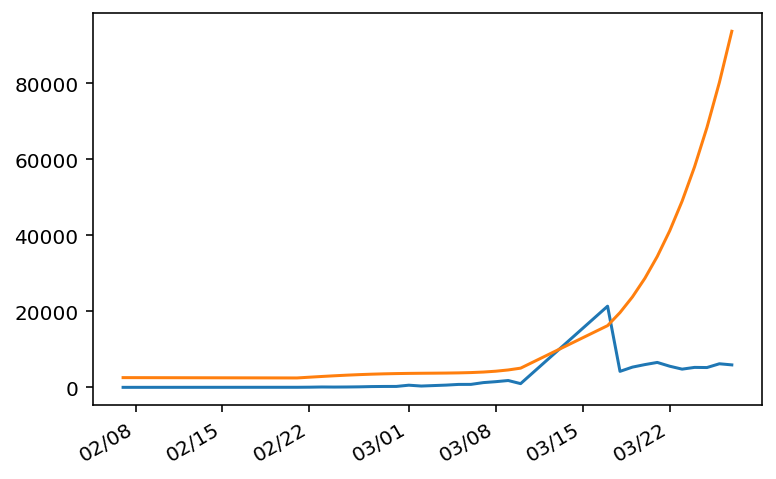

In [127]:
italian_date_offsets = dates_to_date_offsets(italy_smooth.index.values).reshape(-1, 1)[1:]
italian_predictions = world_confirmed_model.predict(polynomial_date_offsets(italian_date_offsets))
plot_time_series_data(italy_smooth.index[1:], italy_smooth["Confirmed"].diff()[1:], np.array(italian_predictions))

### US
Let's look at US cumulative confirmed cases:

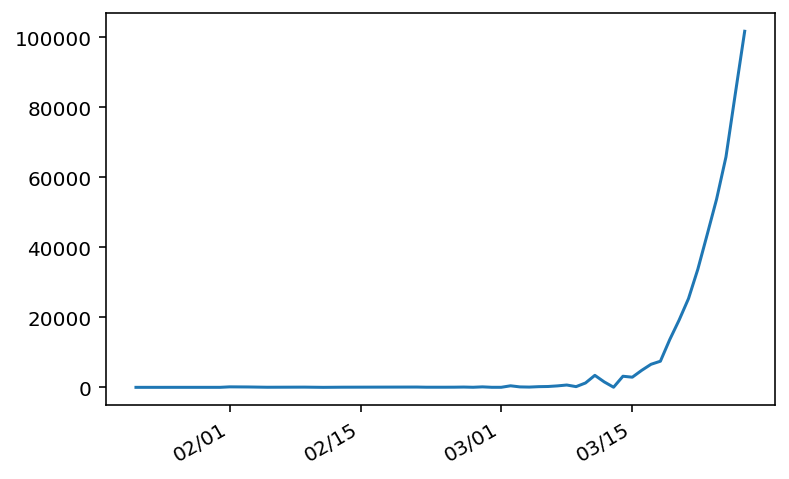

In [16]:
usa = data.loc[data['Country/Region'] == 'US']
usa = usa.groupby(usa.index).sum()
plot_time_series_data(usa.index, usa["Confirmed"])

There's some moderate unexpected noise where cumulative confirmed cases decreases, which you can see more clearly in the daily cases data:

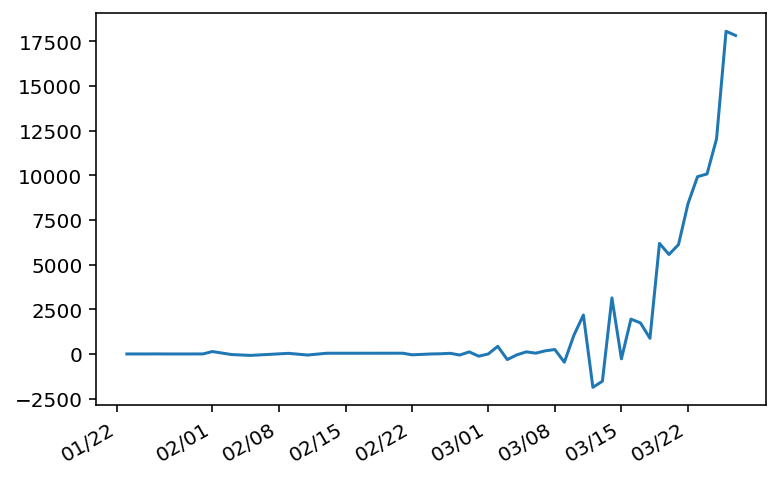

In [17]:
plot_time_series_data(usa.index, usa["Confirmed"].diff())

Unfortunately, removing spikes isn't as straightforward; the greatest increases are on 3/26 and 3/25, respectively, as a consequence of the exponential growth of the data. So we'll ignore the non-monotonic nature of the cumulative confirmed cases.

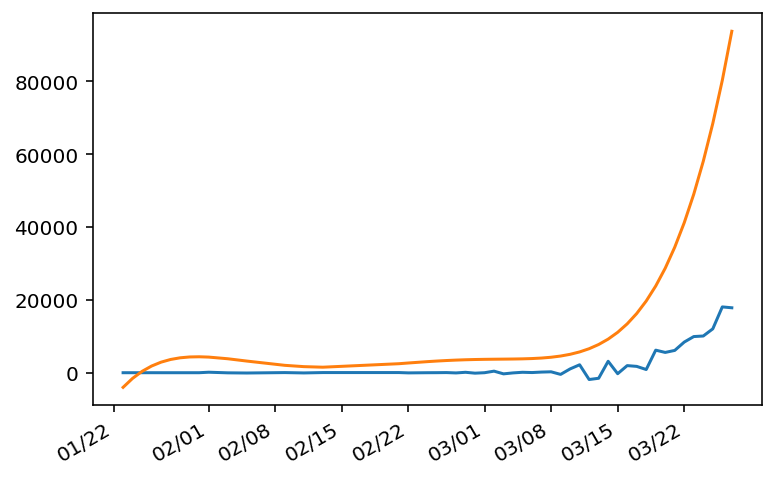

In [128]:
usa_date_offsets = dates_to_date_offsets(usa.index.values).reshape(-1, 1)[1:]
usa_predictions = world_confirmed_model.predict(polynomial_date_offsets(usa_date_offsets))
plot_time_series_data(usa.index[1:], usa["Confirmed"].diff()[1:], np.array(usa_predictions))

### New York State

Let's look at New York cumulative confirmed cases:

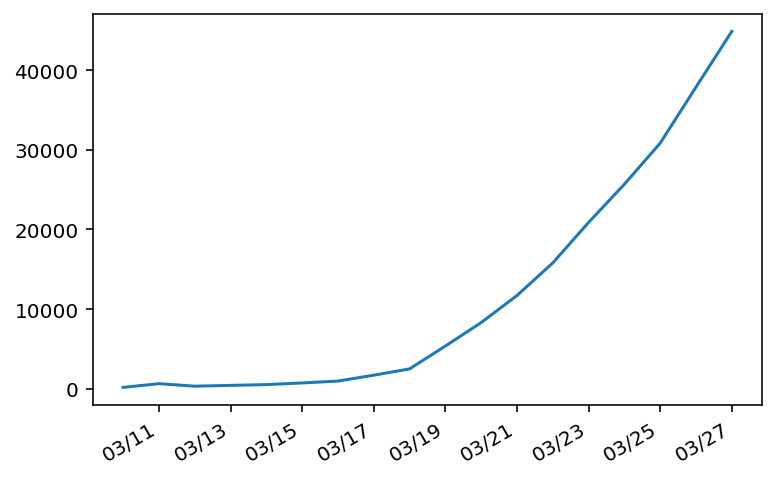

In [18]:
ny = data.loc[data['Province/State'] == 'New York']
ny = ny.groupby(ny.index).sum()
plot_time_series_data(ny.index, ny["Confirmed"])

New York daily occurances clearly show exponential trend:

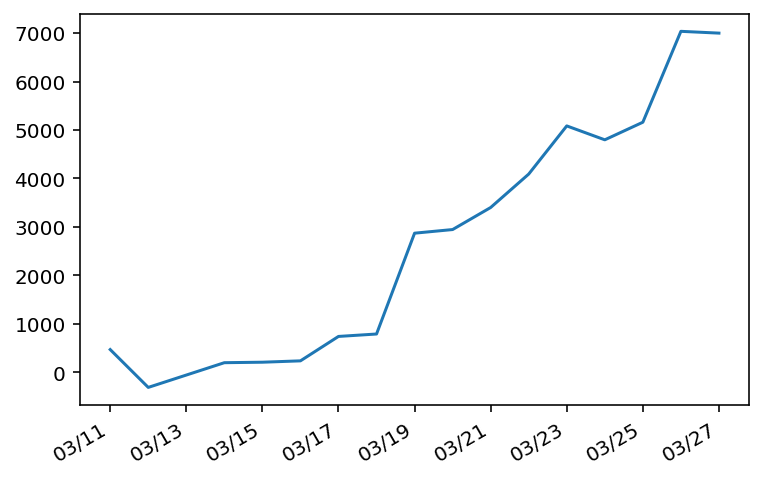

In [19]:
plot_time_series_data(ny.index, ny["Confirmed"].diff())

### Washington DC

Let's look at Washington DC cumulative confirmed cases:

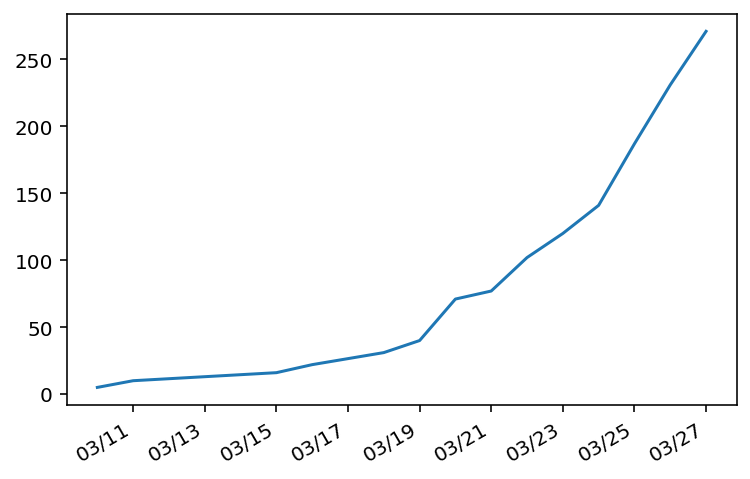

In [22]:
dc = data.loc[data['Province/State'] == 'District of Columbia']
plot_time_series_data(dc.index, dc["Confirmed"])

While daily confirmed cases are noisy, the sample size is small; and it still shows an exponential growth:

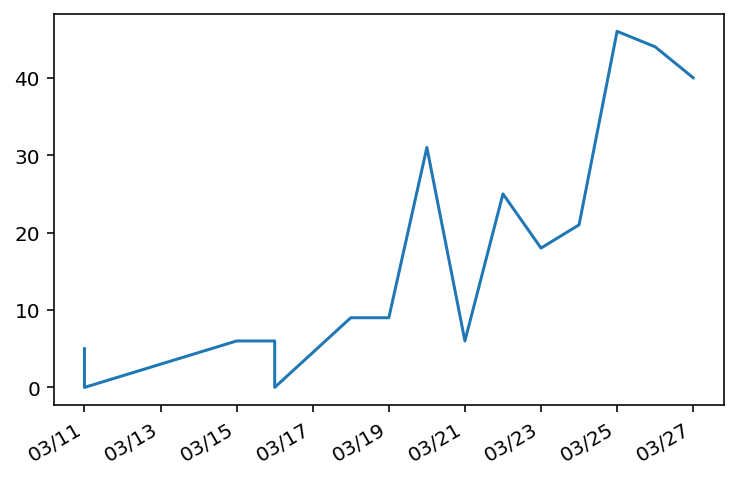

In [21]:
plot_time_series_data(dc.index, dc["Confirmed"].diff())

## Conclusions

### Noisiness of data
* **Hubei**'s daily confirmed observations are very noisy, and are difficult to interpret. Since this is the first region with a COVID-19 pandemic, perhaps this is related to 
* Many other regions (including **worldwide** and **Italy**) contain non-monotonically increasing cumulative observations; it's not clear why this is the case, but these values can be smoothed by iteratively removing observations corresponding maximum or minimum daily deltas. Others (e.g., **US**) also have non-monotonically increase cumulative observations, but they cannot be cleaned using the same technique as they are relatively minor compared to exponential growth of more recently confirmed cases.
* Some regions (including **Hubei** and **Italy**) see sudden spikes of recorded cases that drop off in relatively short periods of time; these may be related to deployment of new testing capabilities, or deployment of more widespread testing.

### Confirmed cases
* No evidence that daily confirmed cases are decreasing in any of the regions in the US that we visualized; DC ends with a two-day decrease, but it's not clear whether this is noise or not.